# Mounting the drive and instanlling the requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#!pip install -q tqdm scikit-learn pandas matplotlib seaborn
base_path = "/content/drive/MyDrive/adarp_project/Sensor Data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# utils.py

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay # Keep PrecisionRecallDisplay for potential future use with the correct method
from sklearn.metrics import classification_report, confusion_matrix
import pprint
import tensorflow as tf
from tensorflow import keras

def check_nan_finiteness(npArray):
  """Check whether there are NaN and infinity values in the Numpy array"""
  print(f"Is NaN {np.any(np.isnan(npArray))}")
  print(f"Is Finite {np.all(np.isfinite(npArray))}")

def remove_nan_infiniteness(npArray):
    """Replace NaN with zero and infinity with large value"""
    return np.nan_to_num(npArray)

def difference_of_list(list1: list, list2: list) -> list:
    """ Given two list, return the difference of the two lists. The difference constains the elements in list1 that are not in list2
    list1: A list
    list2: Another list

    return list
    """

    return list(set(list1).difference(set(list2)))

class PlotLosses(keras.callbacks.Callback):
    """
        Keras Callback to plot the training loss and accuracy of the training and validation sets.
    """
    def __init__(self, metrics):
        self.i = 0
        self.epoch = []
        self.metrics_names = metrics
        self.metrics = {}

        for name in self.metrics_names:
            self.metrics[name] = []
            self.metrics['val_'+name] = []

        self.fig = plt.figure()
        self.logs = []
        self.tf_version = float(tf.__version__[:3])

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.epoch.append(self.i)

        # extract the metrics from the logs
        for name, ax in logs.items():
            # get the training metric
            if name in self.metrics_names:
                self.metrics[name].append(logs.get(name))
            # get the validation metric
            elif 'val_'+name in self.metrics:
                 self.metrics['val_'+name].append(logs.get(name))


        self.i += 1
        f, axes = plt.subplots(len(self.metrics_names), 1, sharex=True,
                               figsize=(12, 4 * len(self.metrics_names)))
        clear_output(wait=True)

        for name, ax in zip(self.metrics_names, axes):
            ax.plot(self.epoch, self.metrics.get(name), label=name)
            ax.plot(self.epoch, self.metrics.get('val_'+name), label="val "+name)
            ax.legend()

        axes[-1].set_xlabel("Epoch")
        plt.show()


def print_confusion_matrix(confusion_matrix, class_names, activities,
  figsize = (12, 6), fontsize=10):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the output figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    fig = fig = plt.gcf()
    heatmap.yaxis.set_ticklabels(activities, rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(activities, rotation=90, ha='right', fontsize=fontsize)
    plt.show()


def get_features_labels_from_df(data_df, shape_y, shape_z):
    """
            Given a dataframe with class as column, separate the features and class label
            and normalize the feature with min-max scaler and encode label as one-hot
            vector.

        Arguments:
        data_df (pandas DataFrame): dataframe
        shape_y (int) : Number of channels for the sensor data
        shape_z (int) : Length of the window segment

        Returns:
        Normalized features in the range (-1.0, 1.0), label, and one hot encoded label
    """
    labels = data_df['Class'].values.astype(int)
    features = data_df.drop(['Class'], axis = 1).values

    scaler = MinMaxScaler(feature_range=(-1.0, 1.0))
    features = scaler.fit_transform(features)

    features = features.reshape(-1, shape_y, shape_z)
    features = np.transpose(features, (0, 2, 1))

    labels_one_hot = keras.utils.to_categorical(labels, np.max(labels)+1)

    return features, labels, labels_one_hot

def min_max_scale(data):
  """
    Min-Max scale the data in the range [-1.0, 1.0]
    The data is expected to have the shape (n_samples, segment_length, n_channels)

    Return the scaled data in the original shape.
  """
  _, segment_length, n_channels = data.shape

  # flatten the data
  features = data.reshape(-1, segment_length * n_channels)

  # scale the data
  scaler = MinMaxScaler(feature_range=(-1.0, 1.0))
  features = scaler.fit_transform(features)

  # reshape the data
  features = features.reshape(-1, n_channels, segment_length)
  features = np.transpose(features, (0, 2, 1))

  return features

def standard_scaler(data):
  """ Normalize the data to have zero mean and unit standard devication
    The data is expected to have the shape (n_samples, segment_length, n_channels)

    Return the scaled data in the original shape.
  """
  _, segment_length, n_channels = data.shape

  # flatten the data
  features = data.reshape(-1, segment_length * n_channels)

  # scale the data
  scaler = StandardScaler(with_mean=False, with_std=False)
  features = scaler.fit_transform(features)

  # reshape the data
  features = features.reshape(-1, n_channels, segment_length)
  features = np.transpose(features, (0, 2, 1))

  return features

def get_cnn_model(input_shape, n_output_classes, learning_rate):
    """
        Returns a 1D CNN model with arch 100 - 50 - GlobalMaxPool1D - 64 - Dropout(0.3) - n_classes.
        We have used this 1D CNN model extensively in Adversarial research projects.

        Arguments:
        input_shape (tuple) : Shape of the input
        n_output_classes (int) : number of output classes
        learning_rate (float) : learning rate for the Adam optimizer

        Returns:
        A 1D CNN model ready for training, with categorical cross entropy loss and Adam optimizer.
    """
    temp_model = keras.Sequential([
        keras.layers.Conv1D(filters = 100, kernel_size = (10), strides = 2, activation = tf.nn.relu, input_shape = input_shape),
        keras.layers.Conv1D(filters = 50, kernel_size = (5), strides = 1, activation = tf.nn.relu),
        keras.layers.GlobalMaxPool1D(),
        #keras.layers.Flatten(),
        keras.layers.Dense(units = 64, activation = tf.nn.relu),
        keras.layers.Dropout(rate = 0.3),
        keras.layers.Dense(units = n_output_classes, activation = tf.nn.softmax)
    ])

    temp_model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
                      metrics = ['accuracy'])

    return temp_model


def save_data(path, data):
    """
        Given a path and data, save the data to the path as a pickle file.

        Arguments:
        path (string) : file path with .pkl extension
        data : data values; can be a single container or multiple containers
    """
    f = open(path, "wb")
    pickle.dump(data, f)
    f.close()

def read_data(path, n_vaues=None):
    """
        Given a path, read the file and return the contents.

        Arguments:
        path (string) : File path with .pkl extension
        n_values (int) : Number of containers expected to be read.
    """

    f = open(path, "rb")
    d = pickle.load(f)
    f.close()
    return d

def stylize_axis(ax, xticks=True, yticks=False, top_right_spines=True,
                    bottom_left_spines=False):
    """
        Given an axis, stylize it by removing ticks and spines. Default choice for
        ticks and spines are given. Modify as needed.

        Arguments:
        ax (matplotlib.axes.Ax): matplotlib axis
        xticks (Boolean): whether to make xticks visible or not (True by Default)
        yticks (Boolean): whether to make yticks visible or not (False by Default)
        top_right_spines (Boolean): whether to make top_right_spines visible or not (True by Default)
        bottom_left_spines (Boolean): whether to make bottom_left_spines visible or not (False by Default)

    """
    if xticks:
        ax.set_xticks([])

    if yticks:
        ax.set_yticks([])

    if top_right_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    if bottom_left_spines:
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)


def print_metrics(met_dict):
    """
        Given a metrics dictionary, print the values.
    """
    print("Loss: {:.3f}".format(met_dict['Loss']))
    print("Accuracy: {:.3f} %".format(met_dict['Accuracy'] * 100))

    print("Precision score: {:.3f}".format(met_dict['Precision']))
    print("Recall score: {:.3f}".format(met_dict["Recall"]))
    print("F1 score: {:.3f}".format(met_dict['F1 Score']))
    print("ROC AUC: {:.3f}".format(met_dict['ROC AUC']))

def precision_recall_f1_score(y_true, y_pred):
  """ Compute precision, recall, and f1 score given y and y predicted.
    y_true and y_pred are labels (not hot encoded)
    Return a dictionary containing Precision, Recall, and F1 Score
  """
  # whether binary or multi-class classification
  if len(np.unique(y_true)) == 2:
    average_case = 'binary'
  else:
    average_case = 'macro'

  recall = recall_score(y_true, y_pred, average=average_case)
  precision = precision_score(y_true, y_pred, average=average_case)
  print(f"Precision {precision} \nRecall {recall}")

  f1_score_cal = f1_score(y_true, y_pred, average=average_case)
  print("F1 score {:.3f}, with formula {:.3f}".format(f1_score_cal,
        2 * ((precision * recall) / (precision + recall))))

  return {'Precision': precision, 'Recall': recall, 'F1 Score': f1_score_cal}


def compute_performance_metrics(model, x, y, metric_names):
    """
        Given a model (TensorFlow) and (x, y), we compute accuracy, loss, True Positive, False Negative,
        False Positive, True Negative, Recall, Precision, f1 score, Average Precision Recall, ROC AUC,
        and classification report.

        Arguments:
            model: tensorflow model
            x: feature vector
            y: label vector (one hot encoded)

        Returns: A dictionary containint, Accuracy, Loss, True Positive, False Positive, False Negative,
                True Negative, Recall, Precision, f1 score, roc_auc_score
    """
    y_true = np.argmax(y, axis=1)
    if len(np.unique(y_true)) > 2:
      print("This only works for binary classification")
      return {}

    # get the metrics
    metrics = model.evaluate(x, y)
    rt = dict()
    for name, val in zip(metric_names, metrics):
      rt[name] = val

    # the loss is always at first position and accuracy the second
    loss, acc = metrics[0], metrics[1] * 100
    print("Accuracy {:.3f}, Loss {:.3f}".format(acc, loss))

    y_probs = model.predict(x)
    y_pred = np.argmax(y_probs, axis=1)

    tp, fp, tn, fn = (0, 0, 0, 0)

    try:
      # we can only do this in binary case
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except:
      print("Not a binary classification problem")

    print("True Positive ", tp)
    print("False Positive ", fp)
    print("True Negative ", tn)
    print("False Negative ", fn)

    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    print("Recall {:.3f}, with formula {:.3f}".format(recall, (tp / (tp + fn))))
    print("Precision {:.3f}, with formula {:.3f}".format(precision, (tp / (tp + fp))))

    f1_score_cal = f1_score(y_true, y_pred)
    print("F1 score {:.3f}, with formula {:.3f}".format(f1_score_cal,
           2 * ((precision * recall) / (precision + recall))))

    print("Average precision score {:.3f}".format(average_precision_score(y_true, y_pred)))

    roc_auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC Score {:.3f}".format(roc_auc))

    clf_report = classification_report(y_true, y_pred, output_dict=True)
    pprint.pprint(clf_report)
    # print(clf_report.keys())

    rt_dict = {'Accuracy': acc,
            'Loss': loss,
            'True Positive': tp,
            'False Positive': fp,
            'True Negative': tn,
            'False Negative': fn,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1_score_cal,
            'ROC AUC': roc_auc
            }

    return rt_dict

def split_into_train_test(X, Y, test_split = 0.25):
    """
        Given data (X, Y), split the data into training and testing sets.
        Validation is 10 percent of the training set.

        Arguments:
            X (numpy.ndarray): Data vector
            Y (numpy.ndarray): Label vector
            test_split (float): Test split (0.25 by default)

        Returns:
            x_train, y_train, x_test, and y_test
    """
    if len(X) != len(Y):
        raise ValueError("X and Y must be the same length")

    # split the data
    random_state = 42
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split, random_state=random_state,
                                                        shuffle=True, stratify=Y)

    # x_val = np.array([])
    # y_val = np.array([])
    # if val_split > 0.0:
    #     x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, random_state=random_state,
    #                                                       shuffle=True, stratify=y_train)

    print("Training set {} \nTest set {}".format(x_train.shape, x_test.shape))
    return x_train, x_test, y_train, y_test

def select_random_samples(data, n_samples):
    """
        @brief: Select n_samples random samples from the data
        @param: data (array)
        @param: n_samples (int) Number of samples to randomly select from the data.

        @return: Randomly selected samples
    """
    length = data.shape[0]
    print(length, n_samples)
    if n_samples >= length:
        return data
    else:
        random_index = np.random.randint(low=0, high=length, size=n_samples)
        return data[random_index]


def get_hot_labels(Y):
    """
        Given label vector, return the one hot encoded label vector.

        Arguments:
            Y (numpy.ndarray): label vector

        Returns:
            One hot encoded label vector.
    """
    return keras.utils.to_categorical(Y, np.max(Y) + 1, dtype=int)


def find_min_max(X):
    """ Return the minimum and maximum value of X """
    return np.min(X), np.max(X)


def load_data_with_preprocessing(data_path):
    """
        Given a data path, load the data (must be in the format (X, Y)) and
        scale the X in range [-1.0, 1.0] and return scaled x and y.

        Arguments:
            data_path (string): Pickle file path

        Returns:
            (X, Y)
    """
    # load the file
    f = open(data_path, "rb")
    try:
        x, y = pickle.load(f)
        f.close()
    except:
        f.close()
        return

    # check for same length
    if len(x) != len(y):
        raise ValueError("Unequal X and Y sizes")

#     print(x.shape, y.shape)
#     wherenane = np.argwhere(np.isnan(x))[:, 1]
#     print(np.unique(wherenane, return_counts=True))
    # do we need preprocessing
    print("Before Scaling: Min - Max {}".format(find_min_max(x)))
    scaler = MinMaxScaler((-1.0, 1.0))
    x = scaler.fit_transform(x)
    print("After Scaling: Min - Max {}".format(find_min_max(x)))

    return x, y


def cross_validation(model_function, X, Y, n_CV, test_split, val_split, batch_size=32, epochs=50):
    """
        @brief: Do cross validation for n_CV times and returns the results.

        @param: model_function : A function that returns the model after calling it.
        @param: X (array): Total data
        @param: Y (array): Total label
        @param: test_split (float): The percentage of samples to be included in the test set
        @param: val_split (float): The percentage of samples to be included in the validation set.
        @param: batch_size (int): Default 32
        @param: epochs (int): Default 50

        @return: Results of the cross validation, a dictionary
    """
    x_tr, x_val, x_ts, y_tr, y_val, y_ts = split_into_train_test(X, Y, test_split, val_split=0.0)
    y_tr_hot = get_hot_labels(y_tr)
    y_ts_hot = get_hot_labels(y_ts)

    results_dict = {}
    metrics_arr = []
    for i in range(n_CV):
        model = model_function()
        results = evaluate_model(model, x_tr, y_tr_hot, x_ts, y_ts_hot, validation_split=val_split,
                                 batch_size=batch_size, epochs=epochs)
        metrics_arr.append(results)
        train_report = compute_performance_metrics(model, x_tr, y_tr)
        test_report = compute_performance_metrics(model, x_ts, y_ts)
        results_dict[i] = {"Training Loss": results[0], "Training Accuracy": results[1],
                            "Test Loss": results[2], "Test Accuracy": results[3],
                            "Training True Positive": train_report[0], "Training False Positive": train_report[1],
                            "Training True Negative": train_report[2], "Training False Negative": train_report[3],
                            "Training Recall": train_report[4], "Training Precision": train_report[5],
                            "Training F1 Score": train_report[6], "Training ROC AUC": train_report[7],
                            "Training Report": train_report[8],
                            "Test True Positive": test_report[0], "Test False Positive": test_report[1],
                            "Test True Negative": test_report[2], "Test False Negative": test_report[3],
                            "Test Recall": test_report[4], "Test Precision": test_report[5],
                            "Test F1 Score": test_report[6], "Test RO AUC": test_report[7],
                            "Test Report": test_report[8]}

    metrics_arr = np.array(metrics_arr).reshape(n_CV, 4)
    print("Average Training Set Accuracy {:.3f}".format(np.average(metrics_arr[:, 1].ravel())))
    print("Average Testing Set Accuracy {:.3f}".format(np.average(metrics_arr[:, 3].ravel())))

    return results_dict


def evaluate_model(model, x_tr, y_tr, x_ts, y_ts, val_split=0.0,
                   batch_size=32, epochs=50, callbacks=[],
                   metric_names=['accuracy', 'loss']):
    """
        @brief: Train the model and evaluate it on training and test set and return the results.

        @param: model: TF model
        @param: x_tr: training x
        @param: y_tr: training y
        @param: x_ts: test x
        @param: y_ts: test y
        @param: val_split: validation set split
        @param: BATCH_SIZE (int): default value 32
        @param: EPOCHS (int): default value 50
        @param: callbacks: TF callback functions
        @param: metric_names

        @return: Train and test metrics
    """
    # plot loss function
    plot_loss_cb = PlotLosses(metric_names)
    cbs = [plot_loss_cb]

    # append other callbacks
    for c in callbacks:
      cbs.append(c)

    # fit the model
    model_history = model.fit(x_tr, y_tr, batch_size = batch_size, epochs = epochs,
                              validation_split = val_split, verbose = 0, callbacks = cbs)

    # get the performance values
    train_metrics = model.evaluate(x_tr, y_tr)
    test_metrics = model.evaluate(x_ts, y_ts)

    return train_metrics, test_metrics


def segment_sensor_reading(values, window_duration, overlap_percentage,
                           sampling_frequency):
    """
        Sliding window segmentation of the values array for the given window
        duration and overlap percentage.

    param values: 1D array of values to be segmented
    param window_duration: Window duration in seconds
    param overlap_percentage: Float value in the range (0 < overlap_percentage < 1)
    param sampling_frequency: Frequency in Hz
    """

    total_length = len(values)
    window_length = sampling_frequency * window_duration
    segments = []
    if(total_length < window_length):
        return segments

    start_index = 0
    end_index = start_index + window_length
    increment_size = int(window_length * (overlap_percentage))

    while(1):
        # print(start_index, end_index)

        # get the segment
        v = values[start_index:end_index]

        # save the segment
        segments.append(v)

        # change the start and end index values
        start_index += increment_size
        end_index += increment_size

        if (start_index > total_length) | (end_index > total_length):
        #print("we are done, no more segments possible")
            break

    segments = np.array(segments).reshape(len(segments), window_length)
    return segments


def create_tf_dataset(X, Y, batch_size, test_size=0.3):
  """ Create train and test TF dataset from X and Y
    The prefetch overlays the preprocessing and model execution of a training step.
    While the model is executing training step s, the input pipeline is reading the data for step s+1.
    AUTOTUNE automatically tune the number for sample which are prefeteched automatically.

    Keyword arguments:
    X -- numpy array
    Y -- numpy array
    batch_size -- integer
  """
  AUTOTUNE = tf.data.experimental.AUTOTUNE

  X = X.astype('float32')
  Y = Y.astype('float32')

  x_tr, x_ts, y_tr, y_ts = train_test_split(X, Y, test_size = 0.3, random_state=42, stratify=Y, shuffle=True)

  print(f"Train size: {x_tr.shape[0]}")
  print(f"Test size: {x_ts.shape[0]}")

  train_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
  train_dataset = train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
  train_dataset = train_dataset.batch(batch_size).prefetch(AUTOTUNE)

  test_dataset = tf.data.Dataset.from_tensor_slices((x_ts, y_ts))
  test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

  return train_dataset, test_dataset

def check_continuity(array):
    """
        Check whether the array contains continous values or not like 1, 2, 3, 4, ..
    """
    max_v = max(array)
    min_v = min(array)
    n = len(array)
#     print(n, min_v, max_v)
    if max_v - min_v + 1 == n:
#         print("Given array has continous values")
        return True
    else:
#         print("Given array is not continous")
        return False


if __name__ == "__main__":
    print("Script with utilities functions used throughout the research projects.")
    print("Availabel Functions are:")
    print(get_cnn_model.__doc__)
    print(get_features_labels_from_df.__doc__)
    print(print_confusion_matrix.__doc__)
    print(PlotLosses.__doc__)
    print(save_data.__doc__)
    print(read_data.__doc__)
    print(stylize_axis.__doc__)
    print(print_metrics.__doc__)
    print(compute_performance_metrics.__doc__)
    print(split_into_train_test.__doc__)
    print(get_hot_labels.__doc__)
    print(find_min_max.__doc__)
    print(load_data_with_preprocessing.__doc__)
    print(evaluate_model.__doc__)
    print(cross_validation.__doc__)
    print(segment_sensor_reading.__doc__)
    print(create_tf_dataset.__doc__)

Script with utilities functions used throughout the research projects.
Availabel Functions are:

        Returns a 1D CNN model with arch 100 - 50 - GlobalMaxPool1D - 64 - Dropout(0.3) - n_classes.
        We have used this 1D CNN model extensively in Adversarial research projects.

        Arguments:
        input_shape (tuple) : Shape of the input
        n_output_classes (int) : number of output classes
        learning_rate (float) : learning rate for the Adam optimizer

        Returns:
        A 1D CNN model ready for training, with categorical cross entropy loss and Adam optimizer.
    

            Given a dataframe with class as column, separate the features and class label
            and normalize the feature with min-max scaler and encode label as one-hot
            vector.

        Arguments:
        data_df (pandas DataFrame): dataframe
        shape_y (int) : Number of channels for the sensor data
        shape_z (int) : Length of the window segment

        Returns:
  

# preprocessing.py

In [3]:
import numpy as np
import scipy.signal as sps
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def resample_data(gsrdata, prevSR, newSR):
  '''Calculates rolling mean
    Function to calculate moving average over the passed data

    Parameters
    ----------
    gsrdata : 1-d array
        array containing the gsr data
    prevSR : int or float
        the previous sample rate of the data
    newSR : int or float
        the new sample rate of the data

    Returns
    -------
    data : 1-d array
        array containing the resampled data
  '''
  number_of_samples = int(round(len(gsrdata) * float(newSR) / prevSR))
  data = sps.resample(gsrdata, number_of_samples)

  return data


def normalization(gsrdata):
  '''Min Max normalization
    Function to calculate normalized gsr data

    Parameters
    ----------
    gsrdata : 1-d array
        array containing the gsr data

    Returns
    -------
    n_gsrdata : 1-d array
        normalized gsr data
  '''
  gsrdata = gsrdata - (np.min(gsrdata))
  gsrdata /= (np.max(gsrdata) - np.min(gsrdata))
  n_gsrdata = gsrdata
  return n_gsrdata

def rolling_mean(data, windowsize, sample_rate):
  '''calculates rolling mean
    Function to calculate moving average over the passed data

    Parameters
    ----------
    data : 1-d array
        array containing the gsr data
    windowsize : int or float
        the moving average window size in seconds
    sample_rate : int or float
        the sample rate of the data set

    Returns
    -------
    rol_mean : 1-d array
        array containing computed rolling mean
  '''
  avg_hr = (np.mean(data))
  data_arr = np.array(data)

  t_windowsize = int(windowsize*sample_rate)
  t_shape = data_arr.shape[:-1] + (data_arr.shape[-1] - t_windowsize + 1, t_windowsize)
  t_strides = data_arr.strides + (data_arr.strides[-1],)
  sep_win = np.lib.stride_tricks.as_strided(data_arr, shape=t_shape, strides=t_strides)
  rol_mean = np.mean(sep_win, axis=1)

  missing_vals = np.array([avg_hr for i in range(0, int(abs(len(data_arr) - len(rol_mean))/2))])
  rol_mean = np.insert(rol_mean, 0, missing_vals)
  rol_mean = np.append(rol_mean, missing_vals)

  #only to catch length errors that sometimes unexplicably occur.
  ##Generally not executed, excluded from testing and coverage
  if len(rol_mean) != len(data): # pragma: no cover
    lendiff = len(rol_mean) - len(data)
    if lendiff < 0:
      rol_mean = np.append(rol_mean, 0)
    else:
      rol_mean = rol_mean[:-1]

  return rol_mean

def min_max_scale(data):
  """
    Min-Max scale the data in the range [-1.0, 1.0]
    The data is expected to have the shape (samples, length, channels)

    Return the scaled data in the original shape.
  """
  _, segment_length, n_channels = data.shape

  # flatten the data
  features = data.reshape(-1, segment_length * n_channels)

  # scale the data
  scaler = MinMaxScaler(feature_range=(-1.0, 1.0))
  features = scaler.fit_transform(features)

  # reshape the data
  features = features.reshape(-1, n_channels, segment_length)
  features = np.transpose(features, (0, 2, 1))

  return features

def standard_scaler(data):
  """ Normalize the data to have zero mean and unit standard devication
    The data is expected to have the shape (n_samples, segment_length, n_channels)

    Return the scaled data in the original shape.
  """
  _, segment_length, n_channels = data.shape

  # flatten the data
  features = data.reshape(-1, segment_length * n_channels)

  # scale the data
  scaler = StandardScaler(with_mean=False, with_std=False)
  features = scaler.fit_transform(features)

  # reshape the data
  features = features.reshape(-1, n_channels, segment_length)
  features = np.transpose(features, (0, 2, 1))

  return features


# filters.py

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt, freqz

def lpf(order = 4, fs = 4, cutoff = 1):
    """Get a low pass filter.

    order: Order for the Butterworth filter
    fs: Sampling frequency
    cutoff: Cut off frequency

    Retuns polynomial of IIR filter.

    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def hpf(order = 1, fs = 4, cutoff = 0.05):
    """Get a high pass filter.

    order: Order for the Butterworth filter
    fs: Sampling frequency
    cutoff: Cut off frequency

    Retuns polynomial of IIR filter.

    """
    nyq = 0.5 * fs
    high = cutoff / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a


def butter_lowpassfilter(data, cutoff, sample_rate, order=2):
  '''Standard Butterworth lowpass filter for 1d-data

    Parameters
    ----------
	data : 1-d array
        array containing the data
    cutoff : int or float
        frequency in Hz that acts as cutoff for filter.
    sample_rate : int or float
        sample rate of the supplied signal
    order : int
        filter order, defines the strength of the roll-off
        around the cutoff frequency.
        default: 2

    Returns
    -------
    y : 1-d array
        filtered data
  '''
  b, a = lpf(order, sample_rate, cutoff)
  y = filtfilt(b, a, data)
  return y


def butter_highpassfilter(data, cutoff, sample_rate, order=2):
    '''Standard Butterworth highpass filter for 1d-data.

    Parameters
    ----------
    data : 1-d array
        array containing the data
    cutoff : int or float
        frequency in Hz that acts as cutoff for filter.
    sample_rate : int or float
        sample rate of the supplied signal
    order : int
        filter order, defines the strength of the roll-off
        around the cutoff frequency.
        default: 2

    Returns
    -------
    y : 1-d array
        filtered data
    '''
    b, a = hpf(order, sample_rate, cutoff)
    y = lfilter(b, a, data)
    return y

def plot_freq_response(sample_rate, cutoff, order, filter_type='lowpass'):
    """ Given sampling frequency and cutoff frequency, draw the frequency response.
    """
    if filter_type == 'lowpass':
        b, a = lpf(order, sample_rate, cutoff)

    elif filter_type == 'highpass':
        b, a = hpf(order, sample_rate, cutoff)

    else:
        print("Undefined filter type. Either Lowpass or Highpass supported")
        return

    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*sample_rate*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*sample_rate)
    plt.title(f"{filter_type} filter frequency fesponse")
    plt.xlabel('Frequency [Hz]')
    plt.grid()

# data_proc_adarp.py

In [5]:
import os
import numpy as np
import csv
from argparse import ArgumentParser

# local imports
#import utils as utl
#import filters as filters
#import preprocessing as preprocessing

participants_folder_names = ['Part 101C',
 'Part 102C',
 'Part 104C',
 'Part 105C',
 'Part 106C',
 'Part 107C',
 'Part 108C',
 'Part 109C',
 'Part 110C',
 'Part 111C',
 'Part 112C']


# # Details
# The sampling rate for
# - Galvanic Skin Response is 4hz
# - Skin Temperature is 4hz
# - Blood Volume Pulse is 64hz
# - Acceleration is 32hz
# - Heart rate is 1hz
#
# For each sensor csv file, the first row is the timestamp for recording start time
# and in some sensor files the second row is sampling frequency. We can use the
# timestamp to put time values next to each row of values in all sensor files,
# and use this timestamp to extract the window around the tag timestamps.
#
# For window size we can experiment with different values, and we will start
# with 25 seconds window and go upto 10 minutes.
#
# We also need to apply filtering on sensor values. For EDA values,
# 1. First-order BW LPF cut-off frequency 5 Hz to remove noise.
# 2. First-order BW HPF cut-off frequency 0.05 Hz to separate SCR and SCL
#
# and for skin temperature
# 1. Second-order BW LPF frequency of 1 Hz
# 2. Second-order BW HPF frequency of 0.1 Hz
#
#
# Unix time is a system for describing a point in time, and is the number of
# seconds that have elapsed since the Unix epoch, minus leap seconds; the Unix
# epoch is 00:00:00 UTC on 1 January 1970.
#
# Every file except the IBI file has sampling frequency in the second row.
# All files have staring time in UNIX timestamp in the first row.

# Constants
E4_EDA_SF = 4
E4_ACC_SF = 32
E4_BVP_SF = 64
E4_HR_SF = 1
E4_TEMP_SF = 4

EDA_CUTOFF_FREQ = 5.0/ E4_EDA_SF

# 40 minutes, 20 minutes before the event and 20 minutes after the event
tag_segment_length_seconds = 40 * 60

# overlapping window segmentation details
window_length_seconds = 60
overlap_seconds = 30          # 50% overlap
overlap_percent = 0.5

# not-stress data is extracted 60 minutes before and after the event markers.
not_stress_buffer_from_tag = 60 * 60

# data_folder = "../Data/Wearable Devices Study Data/"
# output_folder = "../Processed Data/24 seconds window ADARP/"

def get_sensor_data(file_path):
    """
    Load data from a text file located at file_path.
    :param file_path: path to the text file

    """
    data = []
    try:
        data = np.genfromtxt(file_path, delimiter=',')
    except:
        print("Error reading the file {}".format(file_path))

    return data


def get_tag_timestamps(tag_file):
    """
        Open the tag files and retun the tag timestamps as an array.

    :param tag_file: Path to the tags file.
    """

    tag_timestamps = []

    # count = 0
    # for line in open(tag_file): count += 1

    # if count < 2:
    #     return tag_timestamps

    # print(f"{count - 1} tags in {tag_file}")
    with open(tag_file, "r") as read_file:
        csv_reader = csv.reader(read_file)
        # skip the header line
        # next(csv_reader)
        for row in csv_reader:
            # print(row)
            unix_time = float(row[0])
            tag_timestamps.append(unix_time)

    return tag_timestamps


def verify_tags(data_folder):
    total_timestamps = 0
    participants_tags = {}

    for p in participants_folder_names:
        participants_folder_path = data_folder + p + "/"
        part_subfolders = os.listdir(participants_folder_path)
        # print(p)

        temp = 0
        # for each sub-folder in the participants folder
        for sub in part_subfolders:
            path = participants_folder_path + sub

            # get the tag events in this folder
            tag_timestamps = get_tag_timestamps(path + "/tags.csv")

            temp += len(tag_timestamps)
            total_timestamps += len(tag_timestamps)

        participants_tags[p] = temp
        # break
    return participants_tags, total_timestamps


def extract_segments_around_tags(data, tags, segment_size):
    """
        Given data array, tags array and window size extract window size segments
        from the data array around the tags.

    :param data: Data array
    :param tags: An array with tag event times
    :param segment_size: Segment size in seconds

    """
    # return array
    segments = []

    # get the start time: expressed as unit timestamp in UTC i.e., seconds from Jan 1 1970
    start_time = data[0]

    # get the sampling frequency expressed in Hz
    sampling_freq = data[1]

    try:
        if len(start_time):
            start_time = start_time[0]
    except:
        start_time = start_time

    try:
        if len(sampling_freq):
            sampling_freq = sampling_freq[0]
    except:
        sampling_freq = sampling_freq

    # get the sensor data and data length
    sensor_data = data[2:]
    data_length = len(sensor_data)

    # the timestamp corresponding to the last data value
    end_time = start_time + (data_length / sampling_freq)

    # the number of data samples before and after the timestamps
    n_obs = int((segment_size // 2) * sampling_freq)

    skipped_tags = 0

    # for each time stamp in tags
    for timestamp in tags:
        # if the timestamp is within the sensor time array
        if (timestamp >= start_time) & (timestamp <= end_time):
            # how far is the timestamp from the start time.
            difference = int(timestamp - start_time)

            # get the index in the sensor data array, based on the difference of tag timestamp
            position = int(difference * sampling_freq)

            # check is there are enough data points to extract 1 hour of data around the tag.
            check_threshold = 30 * 60 *  sampling_freq        # 30 minutes before and after the tag
            if ((position - check_threshold) < 0) | ((position + check_threshold) > data_length):
                # print("not enough data for 1 hour segment length")
                skipped_tags += 1
                continue

            # window segment position in the data array
            from_ = position - n_obs
            to_ = position + n_obs

            # here we can insert logic to make sure that we have sensor data of length segment_size
            if (from_ < 0) | (to_ > data_length):
                # skip this segment if length is not equal to the segment_size
                print(f"skipping segment From: {from_}, To: {to_}, Data Len: {data_length}")
                continue
            else:
                # get the data segment
                seg = sensor_data[from_:to_]
                segments.append(seg)

            # necessary to make sure that we dont have invalid indices
            # if (from_ < 0):
            #     from_ = 0
            # if (to_ > data_length):
            #     to_ = data_length

    # if skipped_tags != 0:
    #     print(f"Skipped {skipped_tags} ", end=" ")
    return segments


def get_eda_data_around_tags(data_folder, tag_timestamps, segment_size):
    """
        Get EDA segments from the EDA CSV file in data_folder with tag_timestamps
        for segment length of segment_size

    :param data_folder: Path to the folder containing the EDA file
    :param tag_timestamps: An array containing the tag event markers.
    :param segment_size: Segment size in seconds

    """

    # load the data from EDA.csv
    file_path = data_folder + "/EDA.csv"
    processed_EDA = []

    sensor_data = get_sensor_data(file_path)

    if len(sensor_data) == 0:
        return processed_EDA

    segments = extract_segments_around_tags(sensor_data, tag_timestamps, segment_size)
    for p in segments:
        pp = butter_lowpassfilter(np.array(p).ravel(), EDA_CUTOFF_FREQ, E4_EDA_SF, order=2)
        pp = normalization(pp)
        processed_EDA.append(pp)

    return processed_EDA


def get_hr_data_around_tags(data_folder, tag_timestamps, segment_size):
    """
        Get HR segments from the HR CSV file in data_folder with tag_timestamps
        for segment length of segment_size

    :param data_folder: Path to the folder containing the HR file
    :param tag_timestamps: An array containing the tag event markers.
    :param segment_size: Window size in seconds.

    """

    # load the data from EDA.csv
    file_path = data_folder + "/HR.csv"
    sensor_data = get_sensor_data(file_path)
    if len(sensor_data) == 0:
        return []
    else:
        return extract_segments_around_tags(sensor_data, tag_timestamps, segment_size)


def get_temp_data_around_tags(data_folder, tag_timestamps, segment_size):
    """
        Get TEMP segments from the TEMP CSV file in data_folder with tag_timestamps
        for segment length of segment_size

    :param data_folder: Path to the folder containing the TEMP file
    :param tag_timestamps: An array containing the tag event markers.
    :param segment_size: Segment length in seconds.

    """

    # load the data from EDA.csv
    file_path = data_folder + "/TEMP.csv"
    sensor_data = get_sensor_data(file_path)

    if len(sensor_data) == 0:
        return []
    else:
        return extract_segments_around_tags(sensor_data, tag_timestamps, segment_size)


def get_bvp_data_around_tags(data_folder, tag_timestamps, segment_size):
    """
        Get BVP segments from the BVP CSV file in data_folder with tag_timestamps
        for segment length of segment_size

    :param data_folder: Path to the folder containing the BVP file
    :param tag_timestamps: An array containing the tag event markers.
    :param segment_size: Segment length in seconds.

    """

    # load the data from EDA.csv
    file_path = data_folder + "/BVP.csv"
    sensor_data = get_sensor_data(file_path)

    if len(sensor_data) == 0:
        return []
    else:
        return extract_segments_around_tags(sensor_data, tag_timestamps, segment_size)


def get_acc_data_around_tags(data_folder, tag_timestamps, segment_size):
    """
        Get ACC segments from the ACC CSV file in data_folder with tag_timestamps
        for segment length of segment_size

    :param data_folder: Path to the folder containing the ACC file
    :param tag_timestamps: An array containing the tag event markers.
    :param segment_size: Segment length in seconds.

    """
    # load the data from EDA.csv
    file_path = data_folder + "/ACC.csv"
    sensor_data = get_sensor_data(file_path)

    if len(sensor_data) == 0:
        return []
    else:
        return extract_segments_around_tags(sensor_data, tag_timestamps, segment_size)


def extract_segments_for_verified_tags(data_folder, tag_timestamps_folder, segment_length, output_folder=None):
    """
        Extract sensor segment around tag event markers.

        Params
        data_folder -- path to the complete dataset
        tag_timestamps_folder -- path to the folder containing the tag event markers that are verified.
        segment_length -- length of the sensor segment in seconds
        output_folder -- path to store the extracted sensor segment. default None (do not save)

        Return
        Sensor segments for EDA, BVP, ACC, HR, and TEMP
    """

    # total number of segments
    total_segments = 0

    # data containers
    eda_data = []
    hr_data = []
    acc_data = []
    bvp_data = []
    temp_data = []

    for participants_tags_file in os.listdir(tag_timestamps_folder):
        # get the verified tag for the participants
        tag_events = get_tag_timestamps(tag_timestamps_folder  + participants_tags_file)
        if(len(tag_events) == 0):
            continue

        # get the participants identifier
        participant_name = participants_tags_file[:9]
        #print(f"{participant_name} has verified tags {tag_events}")

        # the original folder with participant data
        participants_data_folder = data_folder + participant_name + "/"

        # subfolders within the participants data folder.
        subfolders = os.listdir(participants_data_folder)

        # for each verified tag search all the participants subfolders for matching event markers.
        for tag in tag_events:
            #print(f"Searching for verified tag {tag}")

            # for each sub-folder in the participants folder
            for sub in subfolders:
                sub_folder_path = participants_data_folder + sub

                # get the tag events in this folder
                tag_timestamps = get_tag_timestamps(sub_folder_path + '/tags.csv')
                if(len(tag_timestamps) == 0):
                    continue

                # print(f"{participant_name} event markers {tag_timestamps}")
                # if there are tag events, and if any verified tags are within this list
                # extract data around the verified tag event timestamp
                for stamps in tag_timestamps:
                    if abs(tag - stamps) < 5:
                        #print(f"Verified tag {tag}, event marker {stamps}")
                        total_segments += 1

                        # first EDA
                        values = get_eda_data_around_tags(sub_folder_path, [stamps], segment_length)
                        if len(values):
                            eda_data.extend(values)

                        # second temperature
                        values = get_temp_data_around_tags(sub_folder_path, [stamps], segment_length)
                        if len(values):
                            temp_data.extend(values)

                        # third bvp
                        values = get_bvp_data_around_tags(sub_folder_path, [stamps], segment_length)
                        if len(values):
                            bvp_data.extend(values)

                        # fourth hr
                        values = get_hr_data_around_tags(sub_folder_path, [stamps], segment_length)
                        if len(values):
                            hr_data.extend(values)

                        # fifth acc
                        values = get_acc_data_around_tags(sub_folder_path, [stamps], segment_length)
                        if len(values):
                            acc_data.extend(values)

        # save the participants data
        # if output_folder != None:
        #     print("Saving data of participants " + p)
        #     utl.save_data(output_folder + p + "_EDA_TAG.pkl", np.array(part_eda_data))
        #     utl.save_data(output_folder + p + "_TEMP_TAG.pkl", np.array(part_temp_data))
        #     utl.save_data(output_folder + p + "_HR_TAG.pkl", np.array(part_hr_data))
        #     utl.save_data(output_folder + p + "_BVP_TAG.pkl", np.array(part_bvp_data))
        #     utl.save_data(output_folder + p + "_ACC_TAG.pkl", np.array(part_acc_data))

    return np.array(eda_data), np.array(hr_data), np.array(acc_data), np.array(bvp_data), np.array(temp_data)


def extract_data_around_tags(data_folder, segment_length, save_part_data=False, output_folder=None,
                            include_eda=False, include_bvp=False, include_acc=False, include_hr=False,
                            include_temp=False):
    """
        Extract sensor segment around tag event markers.

        Param
        ===================
        data_folder -- path to the data
        segment_length -- length of the sensor segment to extract in seconds
        save_part_data -- whether to save the participants data or not (default - false)
        output_folder -- path to the directory to save the data (default - none)

        Return
        ===================
        Sensor segment for EDA, BVP, HR, ACC, and TEMP

    """
    # data containers
    eda_data = []
    hr_data = []
    acc_data = []
    bvp_data = []
    temp_data= []

    # for each participants
    for p in participants_folder_names:
        # participants data container
        part_eda_data = []
        part_hr_data = []
        part_acc_data = []
        part_bvp_data = []
        part_temp_data = []

        #print("Extracting data for participants: {}".format(p))
        participants_folder_path = data_folder + p + "/"
        part_subfolders = os.listdir(participants_folder_path)

        # for each sub-folder in the participants folder
        for sub in part_subfolders:
            path = participants_folder_path + sub
#             #print("For subfolder: {}".format(path))

            # get the tag events in this folder
            tag_timestamps = get_tag_timestamps(path + "/tags.csv")

            # if there are tag events, get the sensor values
            if len(tag_timestamps):
                if include_eda:
                    # first EDA
                    values = get_eda_data_around_tags(path, tag_timestamps, segment_length)
                    if len(values):
                        eda_data.extend(values)
                        part_eda_data.extend(values)

                if include_temp:
                    # second temperature
                    values = get_temp_data_around_tags(path, tag_timestamps, segment_length)
                    if len(values):
                        temp_data.extend(values)
                        part_temp_data.extend(values)

                if include_bvp:
                    # third bvp
                    values = get_bvp_data_around_tags(path, tag_timestamps, segment_length)
                    if len(values):
                        bvp_data.extend(values)
                        part_bvp_data.extend(values)

                if include_hr:
                    # fourth hr
                    values = get_hr_data_around_tags(path, tag_timestamps, segment_length)
                    if len(values):
                        hr_data.extend(values)
                        part_hr_data.extend(values)

                if include_acc:
                    # fifth acc
                    values = get_acc_data_around_tags(path, tag_timestamps, segment_length)
                    if len(values):
                        acc_data.extend(values)
                        part_acc_data.extend(values)

        #print(f"Processed participants {p} # eda segments {len(part_eda_data)}")
        #print("Total # eda segments ", len(eda_data))

        # save the participants data
        if (save_part_data)  & (output_folder != None):
            #print("Saving data of participants " + p)
            save_data(output_folder + p + "_EDA_TAG.pkl", np.array(part_eda_data))
            save_data(output_folder + p + "_TEMP_TAG.pkl", np.array(part_temp_data))
            save_data(output_folder + p + "_HR_TAG.pkl", np.array(part_hr_data))
            save_data(output_folder + p + "_BVP_TAG.pkl", np.array(part_bvp_data))
            save_data(output_folder + p + "_ACC_TAG.pkl", np.array(part_acc_data))

    if include_eda & include_temp & include_hr & include_bvp & include_acc:
        return np.array(eda_data), np.array(temp_data), np.array(hr_data), np.array(bvp_data), np.array(acc_data)

    elif include_eda & include_temp & include_hr & include_bvp:
        return np.array(eda_data), np.array(temp_data), np.array(hr_data), np.array(bvp_data)

    elif include_eda & include_temp & include_hr:
        return np.array(eda_data), np.array(temp_data), np.array(hr_data)

    elif include_eda & include_temp:
        return np.array(eda_data), np.array(temp_data)

    elif include_eda:
        return np.array(eda_data)


def get_segments_between_timestamps(data_array, tag_timestamps, pre_and_post_event_marker_len=60*60, segments=[]):
    """
        Extract sensor segment for the not-stress class between event markers. For a given event marker
        timestamp we extract sensor segment until one hour before the event marker and one hour after the event
        marker.

        Param
        ================================
        data_array -- sensor data array
        tag_timestamps -- timestamps of tags to extract data around of
        pre_and_post_event_marker_len -- Time duration to skip data points pre and post event marker
        segments -- Array to store the extracted segments
    """

    if(len(data_array) == 0):
        return segments

    if len(tag_timestamps) == 0:
        segments.append(data_array[2:])
        return segments
    else:
        # extract start time, sampling freq, and n_observations
        start_time = data_array[0]
        sampling_freq = data_array[1]
        try:
            if len(start_time):
                start_time = start_time[0]
        except:
            start_time = start_time

        try:
            if len(sampling_freq):
                sampling_freq = sampling_freq[0]
        except:
            sampling_freq = sampling_freq

        # number of samples to skip before and after the event
        n_observation = int(pre_and_post_event_marker_len * sampling_freq)

        # create the tags, add the start and end time into tags
        tags = [start_time]
        tags.extend(tag_timestamps)
        tags.append(tags[0] + len(data_array) / sampling_freq)

        # sensor data and the length
        data = data_array[2:]
        data_length = len(data)

        # for each tag in the tags array
        for i in range(len(tags)):
            j = i + 1
            if j >= len(tags):
                # if at the end, break free
                break

            # get the starting and end point for the sensor segment.
            start_tag = tags[i] # this is the position of start tag
            end_tag = tags[j] # this is the position of the end tag

#             print("Current tags pair ", (start_tag, end_tag))
            # the positions in the array
            here_ = int((start_tag - start_time) * sampling_freq + n_observation)  # pre_and_post_event_marker_len after the event
            there_ = int((end_tag - start_time) * sampling_freq - n_observation) # pre_and_post_event_marker_len before the event

#             print("Indices ", (here_, there_))
            # if there are data points between the start and end points, extract those data points else ignore them
            if((there_ - here_) > 0):
                pp = data[here_:there_]
                segments.append(pp)

        return segments


def not_stressed_data_from_all_files(data_folder, segment_length_to_skip, save_part_data=False, output_folder=None, segment=False,
                                           include_eda=False, include_bvp=False, include_acc=False, include_hr=False,
                                           include_temp=False):
    """
        Extract data for not-stressed class from all folders.

        Param
        ===================
        data_folder -- path to the data
        segment_length_to_skip -- length of time to skip before and after an tag event
        save_part_data -- whether to save the participants data or not (default - false)
        output_folder -- path to the directory to save the data (default - none)
        segment -- whether to run sliding window or not

        Return
        ===================
        Sensor segment for EDA, BVP, HR, ACC, and TEMP
    """

    # data containers
    eda_data = []
    hr_data = []
    acc_data = []
    bvp_data = []
    temp_data= []

    # for each participants
    for p in participants_folder_names:
        # participants data container
        part_eda_data = []
        part_hr_data = []
        part_acc_data = []
        part_bvp_data = []
        part_temp_data = []

        #print("Extracting data for participants: {}".format(p))
        participants_folder_path = data_folder + p + "/" #IS THIS THE ERROR??? - DESTANIE
        part_subfolders = os.listdir(participants_folder_path)

        # for each sub-folder in the participants folder
        for sub in part_subfolders:
            path = participants_folder_path + sub
#             print("For subfolder: {}".format(path))

            # get the tag events in this folder
            tag_timestamps = get_tag_timestamps(path + "/tags.csv")

            if include_eda:
                # load the EDA data
                data = get_sensor_data(path+"/EDA.csv")
                if len(data) != 0:
                    part_eda_data = get_segments_between_timestamps(data, tag_timestamps, segment_length_to_skip, part_eda_data)

            if include_hr:
                # HR Segments
                data = get_sensor_data(path+"/HR.csv")
                if len(data) != 0:
                    part_hr_data = get_segments_between_timestamps(data, tag_timestamps, segment_length_to_skip, part_hr_data)

            if include_temp:
                # TEMP Segments
                data = get_sensor_data(path+"/TEMP.csv")
                if len(data) != 0:
                    part_temp_data = get_segments_between_timestamps(data, tag_timestamps,segment_length_to_skip, part_temp_data)

            if include_bvp:
                # BVP Segments
                data = get_sensor_data(path+"/BVP.csv")
                if len(data) != 0:
                    part_bvp_data = get_segments_between_timestamps(data, tag_timestamps, segment_length_to_skip, part_bvp_data)

            if include_acc:
                # ACC Segments
                data = get_sensor_data(path+"/ACC.csv")
                if len(data) != 0:
                    part_acc_data = get_segments_between_timestamps(data, tag_timestamps, segment_length_to_skip, part_acc_data)

        # We filter and normalize the EDA data.
        processed_EDA =[]
        for dt in part_eda_data:
            pp = butter_lowpassfilter(np.array(dt).ravel(), EDA_CUTOFF_FREQ, E4_EDA_SF, order=2)
            pp = normalization(pp)
            processed_EDA.append(pp)

        if (save_part_data)  & (output_folder != None):
            # save the participants data
            #print("Saving data of participants " + p)
            save_data(output_folder + p + "_EDA_NO_TAG.pkl", np.array(processed_EDA))
            save_data(output_folder + p + "_TEMP_NO_TAG.pkl", np.array(part_temp_data))
            save_data(output_folder + p + "_HR_NO_TAG.pkl", np.array(part_hr_data))
            save_data(output_folder + p + "_BVP_NO_TAG.pkl", np.array(part_bvp_data))
            save_data(output_folder + p + "_ACC_NO_TAG.pkl", np.array(part_acc_data))

        # add the participants data to the whole data
        eda_data.extend(processed_EDA)
        hr_data.extend(part_hr_data)
        temp_data.extend(part_temp_data)
        bvp_data.extend(part_bvp_data)
        acc_data.extend(part_acc_data)

        #print(f"Processed participants {p} data {len(part_eda_data)}")
        #print("Total data ", len(eda_data))

    if include_eda & include_temp & include_hr & include_bvp & include_acc:
        return np.array(eda_data), np.array(temp_data), np.array(hr_data), np.array(bvp_data), np.array(acc_data)

    elif include_eda & include_temp & include_hr & include_bvp:
        return np.array(eda_data), np.array(temp_data), np.array(hr_data), np.array(bvp_data)

    elif include_eda & include_temp & include_hr:
        return np.array(eda_data), np.array(temp_data), np.array(hr_data)

    elif include_eda & include_temp:
        return np.array(eda_data), np.array(temp_data)

    elif include_eda:
        return np.array(eda_data)

def not_stressed_data_from_zero_tags_files(data_folder, save_part_data=False, output_folder=None, segment=False,
                                           include_eda=False, include_bvp=False, include_acc=False, include_hr=False,
                                           include_temp=False):
    """
        Extract data for not-stressed class from files with zero tag events
        Param
        ===================
        data_folder -- path to the data
        save_part_data -- whether to save the participants data or not (default - false)
        output_folder -- path to the directory to save the data (default - none)
        segment -- whether to run sliding window or not

        Return
        ===================
        Sensor segment for EDA, BVP, HR, ACC, and TEMP
    """
    # data containers
    eda_data = []
    hr_data = []
    acc_data = []
    bvp_data = []
    temp_data= []

    # for each participants
    for p in participants_folder_names:
        part_eda_data = []
        part_hr_data = []
        part_acc_data = []
        part_bvp_data = []
        part_temp_data = []

        #print("Extracting data for participants {}".format(p))
        participants_folder_path = data_folder + p + "/"
        subfolders = os.listdir(participants_folder_path)

        # for each subfolders in the participant folder
        for sub in subfolders:
            path = participants_folder_path + sub
            # get tag timestamps
            tag_timestamps = get_tag_timestamps(path + "/tags.csv")

            if len(tag_timestamps) == 0:
                if include_eda:
                    # load the EDA data
                    data = get_sensor_data(path+"/EDA.csv")
                    if len(data) != 0:
                        part_eda_data.append(data[2:])

                if include_hr:
                    # HR Segments
                    data = get_sensor_data(path+"/HR.csv")
                    if len(data) != 0:
                        part_hr_data.append(data[2:])

                if include_temp:
                    # TEMP Segments
                    data = get_sensor_data(path+"/TEMP.csv")
                    if len(data) != 0:
                        part_temp_data.append(data[2:])

                if include_bvp:
                    # BVP Segments
                    data = get_sensor_data(path+"/BVP.csv")
                    if len(data) != 0:
                        part_bvp_data.append(data[2:])

                if include_acc:
                    # ACC Segments
                    data = get_sensor_data(path+"/ACC.csv")
                    if len(data) != 0:
                        part_acc_data.append(data[2:])

        # We filter and normalize the EDA data.
        processed_EDA =[]
        for p in part_eda_data:
            pp = butter_lowpassfilter(np.array(p).ravel(), EDA_CUTOFF_FREQ, E4_EDA_SF, order=2)
            pp = normalization(pp)
            processed_EDA.append(pp)

        if (save_part_data)  & (output_folder != None):
            # save the participants data
            #print("Saving data of participants " + p)
            save_data(output_folder + p + "_EDA_NO_TAG.pkl", np.array(processed_EDA))
            save_data(output_folder + p + "_TEMP_NO_TAG.pkl", np.array(part_temp_data))
            save_data(output_folder + p + "_HR_NO_TAG.pkl", np.array(part_hr_data))
            save_data(output_folder + p + "_BVP_NO_TAG.pkl", np.array(part_bvp_data))
            save_data(output_folder + p + "_ACC_NO_TAG.pkl", np.array(part_acc_data))

        # add the participants data to the whole data
        eda_data.extend(processed_EDA)
        hr_data.extend(part_hr_data)
        temp_data.extend(part_temp_data)
        bvp_data.extend(part_bvp_data)
        acc_data.extend(part_acc_data)

        #print(f"Processed participants {p} data {len(processed_EDA)}")
        #print("Total data ", len(eda_data))

    if include_eda & include_temp & include_hr & include_bvp & include_acc:
        return np.array(eda_data), np.array(temp_data), np.array(hr_data), np.array(bvp_data), np.array(acc_data)

    elif include_eda & include_temp & include_hr & include_bvp:
        return np.array(eda_data), np.array(temp_data), np.array(hr_data), np.array(bvp_data)

    elif include_eda & include_temp & include_hr:
        return np.array(eda_data), np.array(temp_data), np.array(hr_data)

    elif include_eda & include_temp:
        return np.array(eda_data), np.array(temp_data)

    elif include_eda:
        return np.array(eda_data)


def segment_sensor_data(data_array, sample_rate, window_duration, overlap_percent):
    """
        Overlapping segmentation of data.
    @param data_array: Data to be segmented
    @param sample_rate: Sampling frequency
    @param window_duration: Window size in seconds
    @param overlap_percent: Overlap percentage between consequtive windows.
    """

    window_segments = np.zeros((1, sample_rate * window_duration))

    # get the window segments
    for dt in data_array:
#         print("Current data length ", len(dt))
        segments = segment_sensor_reading(dt, window_duration, overlap_percent, sample_rate)
        if(len(segments)):
            window_segments = np.concatenate([window_segments, segments])

    # return the segments
    window_segments = window_segments[1:, ]
    return window_segments

def segment_sensor_data(data_array, sample_rate, window_duration, overlap_percent, samples_to_drop=None):
    """
        Overlapping segmentation of data with provision to drop samples at defined indices.
    @param data_array: Data to be segmented
    @param sample_rate: Sampling frequency
    @param window_duration: Window size in seconds
    @param overlap_percent: Overlap percentage between consequtive windows.
    @param samples_to_drop: indices of sample that needs to be dropped
    """

    window_segments = np.zeros((1, sample_rate * window_duration))
    dropped_segments = np.zeros((1, sample_rate * window_duration))

    # get the window segments
    for dt in data_array:
#         print("Current data length ", len(dt))
        segments = segment_sensor_reading(dt, window_duration, overlap_percent, sample_rate)

        # drop any samples
        if samples_to_drop != None:
            dropped_segments = np.concatenate((dropped_segments, segments[samples_to_drop].reshape(1, sample_rate * window_duration)))

            try:
                segments = np.delete(segments, samples_to_drop, axis=0)
            except:
                # sometimes we at the end of very begining of the sensor data and there are not enough data stress segment_length > 60
                print(f"Stress windows shape {segments.shape}")
                segments = []

        if(len(segments)):
            window_segments = np.concatenate([window_segments, segments])

    # return the segments
    window_segments = window_segments[1:, ]
    return window_segments, dropped_segments[1:, ]

#if __name__ == '__main__':
   # parser = ArgumentParser("Data processing ADARP")
   # parser.add_argument(
    #    "-i",
     #   "--input_directory",
      #  type=str,
       # required=True,
       # help="Directory that contains the subject data for ADARP"
   # )

    #parser.add_argument(
     #   "-o",
      #  "--output_directory",
       # type=str,
       # required=True,
       # help="Directory to store the processed data"
    #)

    #parser.add_argument(
     #   "-w",
      #  "--window_size",
       # type=int,
       # required=True,
       # help="window size in seconds"
   # )

    #args = parser.parse_args()
    # args.input_directory
    # args.output_directory
    # args.window_size

# data_loader.py

In [6]:

import numpy as np
import sys

#import utils as utl

def create_dataset(stress, not_stress, path=True, reshape=True, train_test=True, balance_classes=False, oversampling_method=None):
    """Create dataset given stress and not-stress data or path.

    stress -- path or data of stress class
    not_stress -- path or data of not-stress class
    path -- whether values of first and seconds arguments are path or not (default True)
    reshape -- whether to reshape the data as (n_samples, window_length, n_channels) (default True)
    train_test -- whether to split the data into train and test sets (default True)
    balance_classes -- whether to balance the data between the classes (default True)
    oversampling_method -- initialized methods from imblearn.over_sampling such as RandomOverSampler, SMOTE, ADASYN

    """
    # if path load the datasets
    if path:
        stress_segments = read_data(stress)
        not_stress_segments = read_data(not_stress)
    else:
        stress_segments = stress
        not_stress_segments = not_stress

    # majority class undersampling: randomly drop samples from not-stress class to have equal number samples
    if balance_classes == True:
        not_stress_segments = select_random_samples(not_stress_segments, stress_segments.shape[0])

    # concatenate the stress and not-stress data
    x = np.concatenate([stress_segments, not_stress_segments], axis=0)
    y = np.concatenate([
        np.ones(len(stress_segments), dtype=int),
        np.zeros(len(not_stress_segments), dtype=int)
    ], axis=0)

    # remove segments from memory
    del stress_segments
    del not_stress_segments
    print(f"X: {x.shape}, Y: {y.shape}")

    x_tr = x
    y_tr = y
    x_ts, y_ts = [], []

    # split into train, test
    if train_test:
        x_tr, x_ts, y_tr, y_ts = split_into_train_val_test(x, y, test_split=0.3)

    # SMOTE oversampling to balance the classes. Do this only for the training set
    if (oversampling_method != None) & (balance_classes == False):
        if len(x_tr.shape) == 2:
            x_tr, y_tr = oversampling_method.fit_resample(x_tr, y_tr)

        elif len(x_tr.shape) == 3:
            org_shape = x_tr.shape
            x_tr, y_tr = oversampling_method.fit_resample(x_tr.reshape(-1, org_shape[1] * org_shape[2]), y_tr)
            x_tr = x_tr.reshape(-1, org_shape[1], org_shape[2])

    # reshape is instructed
    if reshape:
        if len(x_tr.shape) == 2:
            x_tr = x_tr.reshape(-1, x_tr.shape[1], 1)
            if x_ts is np.ndarray:
                x_ts = x_ts.reshape(-1, x_ts.shape[1], 1)

        elif len(x_tr.shape) == 3:
            # the case for acceleration data with 3 channels
            x_tr = x_tr.transpose([0, 2, 1])
            if x_ts is np.ndarray:
                x_ts = x_ts.transpose([0, 2, 1])

    return x_tr, y_tr, x_ts, y_ts

def load_wesad_data(baseline_path, amusement_path, stressed_path, combine_amusement=False, reshape=True, train_test=True):
    """Get training and testing set for the WESAD dataset.

    baseline_path: path to the baseline data
    amusement_path: path to the amusement data
    stressed_path: path to the stressed data

    combine_amusement: whether to combine amusement class or not; default false
    reshape: whether to reshape the 2d data into 3d or not; default true
    train_test; whether to split the data into training and testing set or not; default true

    Return features and labels.
    """
    X, Y = combine_class_data(baseline_path, amusement_path, stressed_path, combine_amusement)

    if reshape:
        X = X.reshape(-1, X.shape[1], 1)

    if train_test:
        x_train, x_test, y_train, y_test = split_into_train_test(X, Y, test_split=0.25)
        return x_train, x_test, y_train, y_test, get_hot_labels(y_train), get_hot_labels(y_test)
    else:
        return X, Y


def combine_class_data(baseline_path, amusement_path, stressed_path, include_amusement = False):
    """
        Load the data for different stress class for the WESAD dataset and return X, Y.
        If amusement is included into the baseline class, the labels assigned to amusement is 0
        same as that of baseline class.

        baseline_path (string): path to baseline data,
        amusement_path (string): path to the amusement data,
        stressed_path (string): path to stressed data
        include_amusement (Boolean): whether to include amusement data into baseline or not.
        By default amusement data is not included into baseline.

        X, Y : NumPy arrays.
    """

    # load the segments
    baseline_segments = read_data(baseline_path)
    stress_segments = read_data(stressed_path)

    # combine the baseline and stress segments
    X = np.concatenate([baseline_segments, stress_segments], axis = 0)
    Y = np.concatenate([np.zeros(baseline_segments.shape[0], dtype=int),
                       np.ones(stress_segments.shape[0], dtype=int)
                       ])
    # include the amusement data is indicated
    if include_amusement:
        amusement_segments = read_data(amusement_path)
        X = np.concatenate([X, amusement_segments])
        Y = np.concatenate([Y, np.zeros(amusement_segments.shape[0], dtype=int)])

    return X, Y


# stress_models.py

In [7]:
import tensorflow as tf
from tensorflow import keras

def get_simple_cnn_model(input_shape, metrics, learning_rate):
    """Create a simple CNN model for EDA based stress binary classification.

    input_shape -- Tuple, needed for the first layer
    metrics -- list, metrics to optimize
    learning_rate -- float, learning rate for the Adam optimizer
    """

    temp_model = keras.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size = (10), strides = 1, activation = tf.nn.relu,
                            input_shape = input_shape, padding='same'),

        keras.layers.Conv1D(filters = 100, kernel_size = (5), strides = 1,
                            activation = tf.nn.relu, padding='same'),
        keras.layers.GlobalMaxPool1D(),

        keras.layers.Dense(units = 264, activation = tf.nn.relu),
        keras.layers.Dropout(rate = 0.3),

        keras.layers.Dense(units = 128, activation = tf.nn.relu),
        keras.layers.Dropout(rate = 0.3),

        keras.layers.Dense(units = 64, activation=tf.nn.relu),
        keras.layers.Dense(units = 1, activation = tf.nn.sigmoid)
    ])

    temp_model.compile(loss = keras.losses.BinaryCrossentropy(),
                       optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                      metrics = metrics)

    return temp_model


def get_supervised_balance_adarp_model(input_shape, metrics, learning_rate):
    """Returns a CNN model for balanced stress dataset.
    After hyperparameterization optimization the best set of hyperparameters were:
        1. batch_size = 147
        2. CNN1 filters = 100
        3. CNN1 kernel size = 5
        4. CNN2 filters = 50
        5. CNN2 kernel size = 10
        6. Dense1 units = 128
        7. Dense2 units = 256
        8. Dense3 units = 64
        9. Dropout1 = 0.1
        10. Dropout2 = 0.3
        11. Learning rate = 0.002558
        12. Optimizer = Adam

        Returns the CNN model.
    """
    temp_model = keras.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size = (5), strides = 1, activation = tf.nn.relu,
                            input_shape = input_shape, padding='same'),

        keras.layers.Conv1D(filters = 50, kernel_size = (10), strides = 1,
                            activation = tf.nn.relu, padding='same'),
        keras.layers.GlobalMaxPool1D(),

        keras.layers.Dense(units = 128, activation = tf.nn.relu),
        keras.layers.Dropout(rate = 0.1),

        keras.layers.Dense(units = 256, activation = tf.nn.relu),
        keras.layers.Dropout(rate = 0.3),

        keras.layers.Dense(units = 64, activation=tf.nn.relu),
        keras.layers.Dense(units = 1, activation = tf.nn.sigmoid)
    ])

    temp_model.compile(loss = keras.losses.BinaryCrossentropy(),
                       optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                      metrics = metrics)

    return temp_model

def get_supervised_full_adarp_model(input_shape, metrics, learning_rate):
    """Returns a large CNN model for binary stress classification.
    After hyperparameterization optimization the best set of hyperparameters were:
        1. Batch size = 100
        2. CNN1 filters = 250
        3. CNN1 kernel size = 5
        4. CNN2 filters = 100
        5. CNN2 kernel size = 5
        6. Dense1 units = 256
        7. Dense2 units = 128
        8. Dense3 units = 64
        9. Dropout1 = 0.1
        10. Dropout2 = 0.1
        11. Learning rate = 0.01157
        12. Optimizer = Adam

        Return the CNN model
    """
    temp_model = keras.Sequential([
        keras.layers.Conv1D(filters=250, kernel_size = (5), strides = 1, activation = tf.nn.relu,
                            input_shape = input_shape, padding='same'),

        keras.layers.Conv1D(filters = 100, kernel_size = (5), strides = 1,
                            activation = tf.nn.relu, padding='same'),
        keras.layers.GlobalMaxPool1D(),

        keras.layers.Dense(units = 256, activation = tf.nn.relu),
        keras.layers.Dropout(rate = 0.1),

        keras.layers.Dense(units = 128, activation = tf.nn.relu),
        keras.layers.Dropout(rate = 0.1),

        keras.layers.Dense(units = 64, activation=tf.nn.relu),
        keras.layers.Dense(units = 2, activation = tf.nn.softmax)
    ])

    temp_model.compile(loss = keras.losses.categorical_crossentropy,
                       optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                      metrics = metrics)

    return temp_model


def get_transfer_wesad_model(input_shape, metrics, learning_rate):
    """After hyperparameterization optimization the best set of hyperparameters were:
        1. Batch size = 120
        2. CNN1 filters = 100
        3. CNN1 kernel size = 10
        4. CNN2 filters = 50
        5. CNN2 kernel size = 5
        6. Dense1 units = 128
        7. Dense2 units = 64
        8. Dense3 units = 128
        9. Dropout1 = 0.2
        10. Dropout2 = 0.3
        11. Learning rate = 0.0154
        12. Optimizer = Adam

        For test loss of 0.2275
        Return the CNN model
    """
    temp_model = keras.Sequential([
        keras.layers.Conv1D(filters = 100, kernel_size = (5), strides = 1, activation = tf.nn.relu,
                            input_shape = input_shape),

        keras.layers.Conv1D(filters = 100, kernel_size = (10), strides = 1, activation = tf.nn.relu),
        keras.layers.GlobalMaxPool1D(),

        keras.layers.Dense(units = 128, activation = tf.nn.relu),
        keras.layers.Dropout(rate = 0.3),

        keras.layers.Dense(units = 64, activation = tf.nn.relu, name='penultimate_layer'),
        keras.layers.Dropout(rate = 0.2),
        keras.layers.Dense(units = 2, activation = tf.nn.softmax)
    ])

    temp_model.compile(loss = keras.losses.categorical_crossentropy,
                       optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                      metrics = metrics)

    return temp_model


def get_transfer_adarp_model(input_shape, metrics, learning_rate):
    """After hyperparameterization optimization the best set of hyperparameters were:
        1. Batch size = 106
        2. CNN1 filters = 250
        3. CNN1 kernel size = 2
        4. CNN2 filters = 100
        5. CNN2 kernel size = 10
        6. Dense1 units = 64
        7. Dense2 units = 128
        8. Dense3 units = 128
        9. Dropout1 = 0.1
        10. Dropout2 = 0.1
        11. Learning rate = 0.002046
        12. Optimizer = Adam

        For test loss of 0.5263
        Return the CNN model
    """
    temp_model = keras.Sequential([
        keras.layers.Conv1D(filters=250, kernel_size=(2), strides=1, activation=tf.nn.relu,
                            input_shape=input_shape, padding='same'),

        keras.layers.Conv1D(filters=100, kernel_size=(10), strides=1,
                            activation=tf.nn.relu, padding='same'),
        keras.layers.GlobalMaxPool1D(),

        keras.layers.Dense(units=64, activation=tf.nn.relu),
        keras.layers.Dropout(rate=0.1),

        keras.layers.Dense(units=128, activation=tf.nn.relu),
        keras.layers.Dropout(rate=0.1),

        keras.layers.Dense(units=128, activation=tf.nn.relu),
        keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    ])

    temp_model.compile(loss=keras.losses.BinaryCrossentropy(),
                       optimizer=keras.optimizers.Adam(learning_rate = learning_rate),
                      metrics=metrics)

    return temp_model

# Ryan Gosling ❣

Saving stay-strong-my-fellow-test-takers-v0-3t54cpgpyraf1.jpeg to stay-strong-my-fellow-test-takers-v0-3t54cpgpyraf1.jpeg


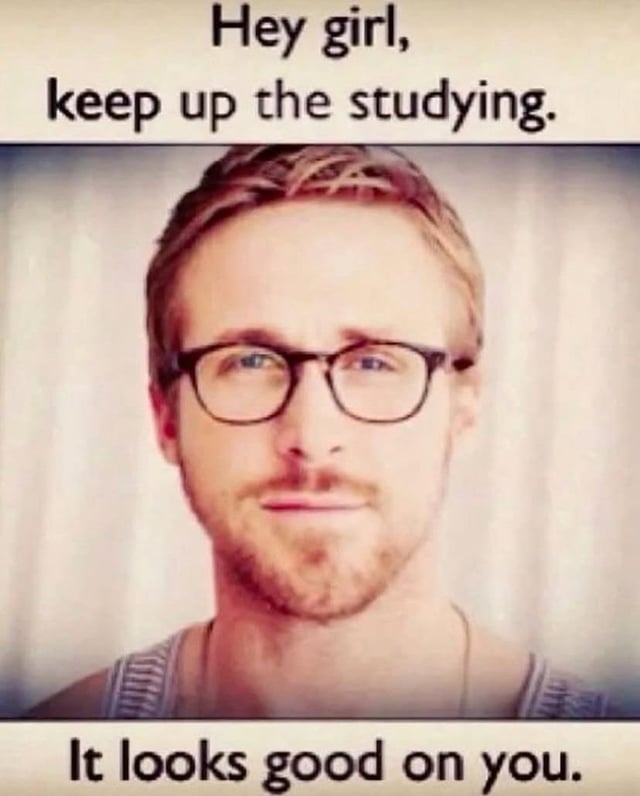

In [16]:
from google.colab import files
from IPython.display import Image, display

uploaded = files.upload()

for filename in uploaded.keys():
    display(Image(filename=filename))

# Gemni Code
Now I will define and train the CNN model using the `get_simple_cnn_model` function from your `stress_models.py` file.

In [17]:
# Define the input shape for the model
input_shape = (x_train.shape[1], x_train.shape[2])

# Define the metrics to track during training
metrics = ['accuracy']

# Define the learning rate for the optimizer
learning_rate = 0.001

# Get the model using the defined parameters
model = get_simple_cnn_model(input_shape, metrics, learning_rate)

# Print the model summary
model.summary()

# Define training parameters
BATCH_SIZE = 32
EPOCHS = 50

# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test)
)

NameError: name 'x_train' is not defined

# Define paths

In [91]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
#base_path = "/content/drive/MyDrive/adarp_project/Sensor Data/Part 107C"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import os
os.listdir('/content/drive/MyDrive/adarp_project/Sensor Data')
!ls "/content/drive/MyDrive/adarp_project/Sensor Data"

from google.colab import files
uploaded = files.upload()

os.listdir()

'Part 101C'  'Part 104C'  'Part 106C'  'Part 108C'  'Part 110C'  'Part 112C'
'Part 102C'  'Part 105C'  'Part 107C'  'Part 109C'  'Part 111C'


['.config',
 'drive',
 'README.md',
 'LICENSE',
 'data_proc_adarp.py',
 'stress_models.py',
 'preprocessing.py',
 '__pycache__',
 'Requirements.txt',
 'utils.py',
 'data_loader.py',
 'filters.py',
 'sample_data']

# Just the positives

In [8]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

base_path = "/content/drive/MyDrive/adarp_project/Sensor Data"
segment_size = 60

X = []
y = []

all_participants = sorted(os.listdir(base_path))

for participant in all_participants:
    participant_path = os.path.join(base_path, participant)
    if not os.path.isdir(participant_path):
        continue

    valid_count = 0  # count usable segments per participant

    for day in sorted(os.listdir(participant_path)):
        day_path = os.path.join(participant_path, day)
        tag_file_path = os.path.join(day_path, 'tags.csv')

        if not os.path.isdir(day_path) or not os.path.exists(tag_file_path):
            continue

        tag_times = get_tag_timestamps(tag_file_path)
        if not tag_times:
            print(f"Skipping (empty tags): {day_path}")
            continue

        try:
            eda_segments = get_eda_data_around_tags(day_path, tag_times, segment_size)
            for seg in eda_segments:
                if len(seg) == 0:
                    continue
                features = [np.mean(seg)]  # simple feature: mean EDA
                X.append(features)
                y.append(1)
                valid_count += 1
        except Exception as e:
            print(f"🥺 Error on {day_path}: {e}")

    print(f"✅ {participant} contributed {valid_count} usable samples")

# Final dataset
X = np.array(X)
y = np.array(y)

print(f"\n✅ Final dataset shape: {X.shape}")

if len(X) < 2:
    print("🥺 Hey queen, still not enough samples. Try again with more participants or sensors.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("\n Classification Report:\n", classification_report(y_test, y_pred))
    print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Skipping (empty tags): /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190429-184613
Skipping (empty tags): /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190430-034436
Skipping (empty tags): /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190430-234943
Skipping (empty tags): /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190501-173539
Skipping (empty tags): /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190503-171525
Skipping (empty tags): /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190505-153004
Skipping (empty tags): /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190506-173700
Skipping (empty tags): /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190507-181335
Skipping (empty tags): /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190508-174012
✅ Part 101C contributed 4 usable samples
Skipping (empty tags): /content/

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Positives again

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        55

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


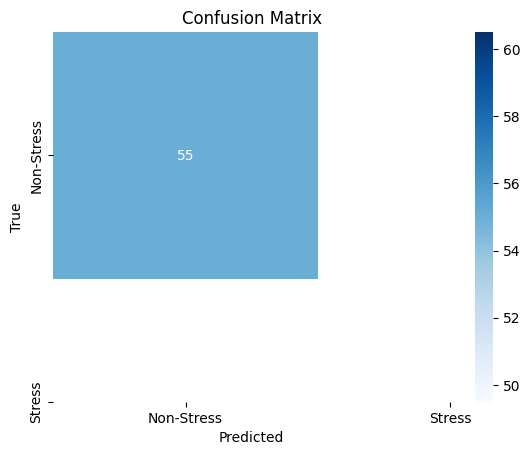

In [9]:
# Train/Test split
X = np.array(X)
y = np.array(y)

if len(X) == 0:
    print("🥺 No data to train on.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

    # Train model
    clf = RandomForestClassifier(n_estimators=100, random_state=22)
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Stress', 'Stress'], yticklabels=['Non-Stress', 'Stress'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



# Expanding

+ The hard part is getting the negatives to work
+ Plus obvi need other metrics and not just the eda

In [11]:
import os
import numpy as np
import pandas as pd
from pandas.errors import EmptyDataError
import time

# — Constants —
POS_SEGMENT_LENGTH = 40 * 60        # 40 minutes
NOT_STRESS_BUFFER   = 60 * 60       # 60 minutes

# — Helper for negatives —
def get_negative_segments(session_path, tag_timestamps, buffer_length):
    neg_segments = []
    fp = os.path.join(session_path, 'EDA.csv')
    if os.path.isfile(fp):
        try:
            data = get_sensor_data(fp)    # your existing loader
            neg_segments = get_segments_between_timestamps(
                data, tag_timestamps, buffer_length, neg_segments
            )
        except EmptyDataError:
            print(f"⚠️ Empty EDA.csv, skipping negatives in {session_path}")
    return neg_segments

# — Main loop —
data_folder = '/content/drive/MyDrive/adarp_project/Sensor Data/'
all_pos_eda = []
all_neg_eda = []

start_time = time.time()

for p_idx, p in enumerate(os.listdir(data_folder)):
    part_dir = os.path.join(data_folder, p)
    if not os.path.isdir(part_dir):
        continue
    print(f"\nParticipant {p_idx+1}: {p}")
    for sess_idx, sess in enumerate(os.listdir(part_dir)):
        sess_path = os.path.join(part_dir, sess)
        tag_file  = os.path.join(sess_path, 'tags.csv')
        if not os.path.isfile(tag_file):
            continue

        print(f"  Session {sess_idx+1}: {sess}")

        # load timestamps
        try:
            tags = get_tag_timestamps(tag_file)
        except EmptyDataError:
            print(f"    ⚠️ Empty tags.csv, skipping {sess_path}")
            continue

        if not tags:
            # no valid timestamps
            print(f"    ⚠️ No valid tags, skipping {sess_path}")
            continue

        # — positives —
        try:
            pos = get_eda_data_around_tags(sess_path, tags, POS_SEGMENT_LENGTH)
        except EmptyDataError:
            print(f"    ⚠️ Empty EDA.csv, skipping positives in {sess_path}")
            pos = []
        all_pos_eda.extend(pos)
        print(f"    ✅ {len(pos)} positive segments added (total {len(all_pos_eda)})")

        # — negatives —
        neg = get_negative_segments(sess_path, tags, NOT_STRESS_BUFFER)
        all_neg_eda.extend(neg)
        print(f"    ✅ {len(neg)} negative segments added (total {len(all_neg_eda)})")

    # TEMP: To test, break after first participant (remove after debug)
    # break

elapsed = time.time() - start_time
print(f"\n✅ Extracted {len(all_pos_eda)} positive EDA segments")
print(f"✅ Extracted {len(all_neg_eda)} negative EDA segments")
print(f"⏱️ Total elapsed time: {elapsed:.1f} seconds")



Participant 2: Part 101C
  Session 1: A01fb9_190428-100948
    ✅ 0 positive segments added (total 0)
    ✅ 0 negative segments added (total 0)
  Session 2: A01f4c_190503-171525
    ⚠️ No valid tags, skipping /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190503-171525
  Session 3: A01f4c_190508-174012
    ⚠️ No valid tags, skipping /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190508-174012
  Session 4: A01f4c_190430-034436
    ⚠️ No valid tags, skipping /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190430-034436
  Session 5: A01fb9_190428-184956
    ✅ 0 positive segments added (total 0)
    ✅ 0 negative segments added (total 0)
  Session 6: A01f4c_190430-234943
    ⚠️ No valid tags, skipping /content/drive/MyDrive/adarp_project/Sensor Data/Part 101C/A01f4c_190430-234943
  Session 7: A01fb9_190502-211553
    ✅ 0 positive segments added (total 0)
    ✅ 1 negative segments added (total 1)
  Session 8: A01fb9_190503-125647
    ✅ 

# Features

In [12]:
import numpy as np
import pandas as pd

def extract_basic_features(eda_segments, label):
    features = []
    for idx, seg in enumerate(eda_segments):
        # Handle both arrays and DataFrame segments
        if hasattr(seg, 'values'):  # If DataFrame, use first column
            seg_arr = np.array(seg.values).flatten()
        else:
            seg_arr = np.array(seg).flatten()
        if len(seg_arr) == 0 or np.isnan(seg_arr).all():
            continue
        feats = {
            'segment_id': f"{label}_{idx}",
            'label': label,
            'mean_eda': np.mean(seg_arr),
            'std_eda': np.std(seg_arr),
            'min_eda': np.min(seg_arr),
            'max_eda': np.max(seg_arr),
            'range_eda': np.max(seg_arr) - np.min(seg_arr),
            'skew_eda': pd.Series(seg_arr).skew(),
            'kurt_eda': pd.Series(seg_arr).kurt()
        }
        features.append(feats)
    return pd.DataFrame(features)

# Extract features
pos_df = extract_basic_features(all_pos_eda, 'positive')
neg_df = extract_basic_features(all_neg_eda, 'negative')
eda_features_df = pd.concat([pos_df, neg_df], ignore_index=True).dropna()

print(eda_features_df.head())


   segment_id     label  mean_eda   std_eda  min_eda  max_eda  range_eda  \
0  positive_0  positive  0.293027  0.127064      0.0      1.0        1.0   
1  positive_1  positive  0.252175  0.218871      0.0      1.0        1.0   
2  positive_2  positive  0.578058  0.120634      0.0      1.0        1.0   
3  positive_3  positive  0.578058  0.120635      0.0      1.0        1.0   
4  positive_4  positive  0.237518  0.283369      0.0      1.0        1.0   

   skew_eda  kurt_eda  
0  0.339158 -1.001581  
1  1.233097  0.736069  
2  0.829439  1.178828  
3  0.829436  1.178815  
4  1.233499  0.151203  


# Visuals

<Figure size 700x500 with 0 Axes>

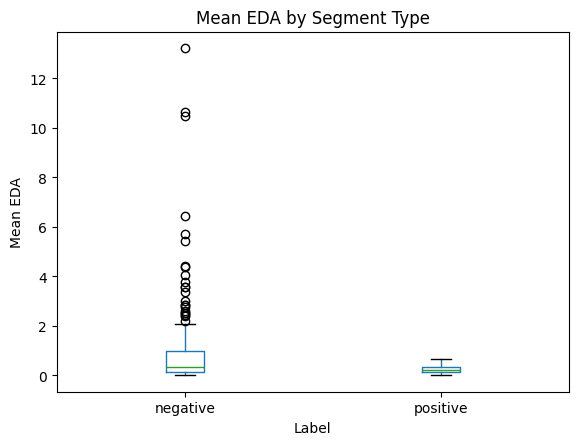

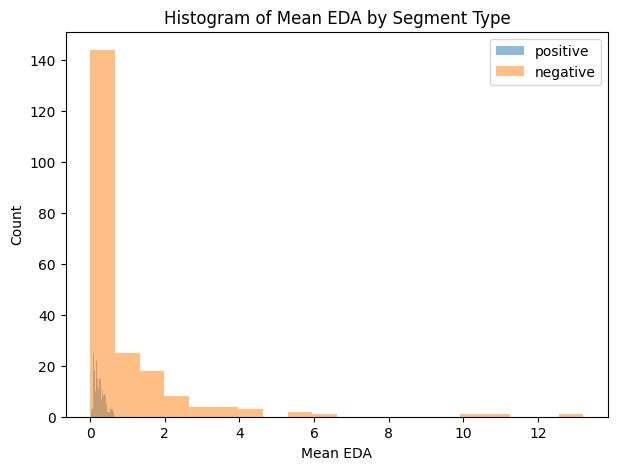

In [13]:
import matplotlib.pyplot as plt

# Boxplot for mean EDA
plt.figure(figsize=(7,5))
eda_features_df.boxplot(column='mean_eda', by='label', grid=False)
plt.title('Mean EDA by Segment Type')
plt.suptitle('')
plt.xlabel('Label')
plt.ylabel('Mean EDA')
plt.show()

# Histogram for mean EDA
plt.figure(figsize=(7,5))
for lbl in ['positive', 'negative']:
    subset = eda_features_df[eda_features_df['label'] == lbl]['mean_eda']
    plt.hist(subset, bins=20, alpha=0.5, label=lbl)
plt.legend()
plt.title('Histogram of Mean EDA by Segment Type')
plt.xlabel('Mean EDA')
plt.ylabel('Count')
plt.show()


# the ml pipeline yippeee

Confusion Matrix:
[[42  1]
 [ 0 36]]

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.98      0.99        43
    positive       0.97      1.00      0.99        36

    accuracy                           0.99        79
   macro avg       0.99      0.99      0.99        79
weighted avg       0.99      0.99      0.99        79



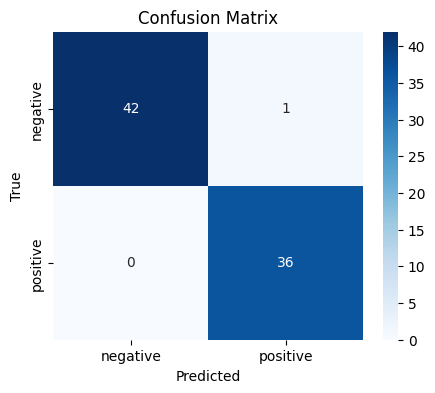

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prepare features and labels
X = eda_features_df[['mean_eda', 'std_eda', 'min_eda', 'max_eda', 'range_eda', 'skew_eda', 'kurt_eda']]
y = eda_features_df['label'].map({'positive':1, 'negative':0})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22, stratify=y)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=22)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
